# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.15KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

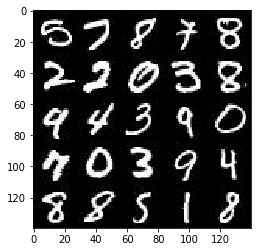

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

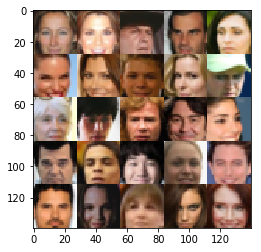

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 3.1031... Generator Loss: 0.2083
Epoch 1/2... Batch 20... Discriminator Loss: 0.0836... Generator Loss: 7.6170
Epoch 1/2... Batch 30... Discriminator Loss: 0.8799... Generator Loss: 2.2122
Epoch 1/2... Batch 40... Discriminator Loss: 0.3047... Generator Loss: 1.8150
Epoch 1/2... Batch 50... Discriminator Loss: 0.1667... Generator Loss: 2.6403
Epoch 1/2... Batch 60... Discriminator Loss: 1.6327... Generator Loss: 1.2450
Epoch 1/2... Batch 70... Discriminator Loss: 0.5928... Generator Loss: 2.4377
Epoch 1/2... Batch 80... Discriminator Loss: 1.0971... Generator Loss: 5.7639
Epoch 1/2... Batch 90... Discriminator Loss: 0.6418... Generator Loss: 1.9281
Epoch 1/2... Batch 100... Discriminator Loss: 0.4620... Generator Loss: 2.0002


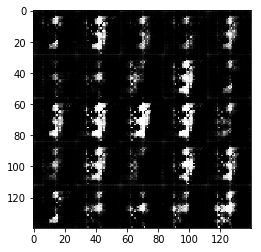

Epoch 1/2... Batch 110... Discriminator Loss: 0.2555... Generator Loss: 2.1249
Epoch 1/2... Batch 120... Discriminator Loss: 0.2531... Generator Loss: 3.3515
Epoch 1/2... Batch 130... Discriminator Loss: 1.0790... Generator Loss: 4.2732
Epoch 1/2... Batch 140... Discriminator Loss: 2.5053... Generator Loss: 6.0656
Epoch 1/2... Batch 150... Discriminator Loss: 0.5220... Generator Loss: 3.4506
Epoch 1/2... Batch 160... Discriminator Loss: 0.8781... Generator Loss: 0.9666
Epoch 1/2... Batch 170... Discriminator Loss: 4.0130... Generator Loss: 8.6187
Epoch 1/2... Batch 180... Discriminator Loss: 1.2763... Generator Loss: 1.7867
Epoch 1/2... Batch 190... Discriminator Loss: 0.7257... Generator Loss: 1.6275
Epoch 1/2... Batch 200... Discriminator Loss: 0.8629... Generator Loss: 1.2677


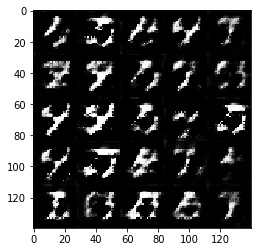

Epoch 1/2... Batch 210... Discriminator Loss: 0.5402... Generator Loss: 2.9752
Epoch 1/2... Batch 220... Discriminator Loss: 1.2069... Generator Loss: 5.1624
Epoch 1/2... Batch 230... Discriminator Loss: 1.0036... Generator Loss: 2.3069
Epoch 1/2... Batch 240... Discriminator Loss: 0.3758... Generator Loss: 2.1258
Epoch 1/2... Batch 250... Discriminator Loss: 0.3023... Generator Loss: 2.2686
Epoch 1/2... Batch 260... Discriminator Loss: 1.5072... Generator Loss: 0.4546
Epoch 1/2... Batch 270... Discriminator Loss: 0.6572... Generator Loss: 2.0572
Epoch 1/2... Batch 280... Discriminator Loss: 4.8287... Generator Loss: 9.5696
Epoch 1/2... Batch 290... Discriminator Loss: 0.6164... Generator Loss: 1.7720
Epoch 1/2... Batch 300... Discriminator Loss: 0.6345... Generator Loss: 1.5558


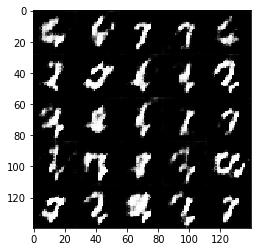

Epoch 1/2... Batch 310... Discriminator Loss: 0.7469... Generator Loss: 1.4326
Epoch 1/2... Batch 320... Discriminator Loss: 0.7863... Generator Loss: 2.1138
Epoch 1/2... Batch 330... Discriminator Loss: 1.9143... Generator Loss: 4.2104
Epoch 1/2... Batch 340... Discriminator Loss: 1.1809... Generator Loss: 1.2576
Epoch 1/2... Batch 350... Discriminator Loss: 1.0620... Generator Loss: 0.5938
Epoch 1/2... Batch 360... Discriminator Loss: 0.7024... Generator Loss: 1.2647
Epoch 1/2... Batch 370... Discriminator Loss: 1.7280... Generator Loss: 0.4140
Epoch 1/2... Batch 380... Discriminator Loss: 0.8284... Generator Loss: 1.2379
Epoch 1/2... Batch 390... Discriminator Loss: 1.1361... Generator Loss: 2.8885
Epoch 1/2... Batch 400... Discriminator Loss: 0.7903... Generator Loss: 1.4020


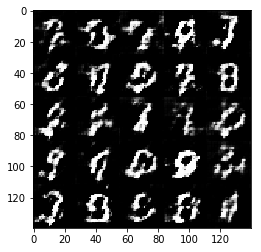

Epoch 1/2... Batch 410... Discriminator Loss: 1.0047... Generator Loss: 0.7029
Epoch 1/2... Batch 420... Discriminator Loss: 0.5855... Generator Loss: 1.4300
Epoch 1/2... Batch 430... Discriminator Loss: 1.0229... Generator Loss: 1.1455
Epoch 1/2... Batch 440... Discriminator Loss: 0.5979... Generator Loss: 1.8262
Epoch 1/2... Batch 450... Discriminator Loss: 1.0209... Generator Loss: 2.3763
Epoch 1/2... Batch 460... Discriminator Loss: 0.5956... Generator Loss: 1.6097
Epoch 1/2... Batch 470... Discriminator Loss: 0.6685... Generator Loss: 2.4055
Epoch 1/2... Batch 480... Discriminator Loss: 0.9264... Generator Loss: 3.7623
Epoch 1/2... Batch 490... Discriminator Loss: 0.5410... Generator Loss: 1.9922
Epoch 1/2... Batch 500... Discriminator Loss: 0.8030... Generator Loss: 1.0563


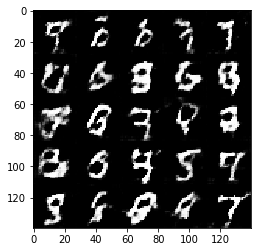

Epoch 1/2... Batch 510... Discriminator Loss: 1.0662... Generator Loss: 0.8231
Epoch 1/2... Batch 520... Discriminator Loss: 0.9352... Generator Loss: 1.6793
Epoch 1/2... Batch 530... Discriminator Loss: 1.0079... Generator Loss: 1.7180
Epoch 1/2... Batch 540... Discriminator Loss: 1.5472... Generator Loss: 0.4769
Epoch 1/2... Batch 550... Discriminator Loss: 0.5060... Generator Loss: 1.9475
Epoch 1/2... Batch 560... Discriminator Loss: 1.6520... Generator Loss: 0.3047
Epoch 1/2... Batch 570... Discriminator Loss: 1.1449... Generator Loss: 0.7152
Epoch 1/2... Batch 580... Discriminator Loss: 1.7051... Generator Loss: 4.4297
Epoch 1/2... Batch 590... Discriminator Loss: 1.0496... Generator Loss: 0.7613
Epoch 1/2... Batch 600... Discriminator Loss: 1.5816... Generator Loss: 0.3841


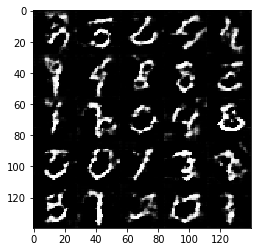

Epoch 1/2... Batch 610... Discriminator Loss: 1.6557... Generator Loss: 0.3978
Epoch 1/2... Batch 620... Discriminator Loss: 1.1131... Generator Loss: 0.6374
Epoch 1/2... Batch 630... Discriminator Loss: 0.7961... Generator Loss: 1.6063
Epoch 1/2... Batch 640... Discriminator Loss: 0.9008... Generator Loss: 1.4991
Epoch 1/2... Batch 650... Discriminator Loss: 1.1555... Generator Loss: 2.6895
Epoch 1/2... Batch 660... Discriminator Loss: 0.7202... Generator Loss: 1.2381
Epoch 1/2... Batch 670... Discriminator Loss: 0.8818... Generator Loss: 1.1407
Epoch 1/2... Batch 680... Discriminator Loss: 0.7488... Generator Loss: 1.1742
Epoch 1/2... Batch 690... Discriminator Loss: 0.9610... Generator Loss: 1.7384
Epoch 1/2... Batch 700... Discriminator Loss: 0.6411... Generator Loss: 1.1558


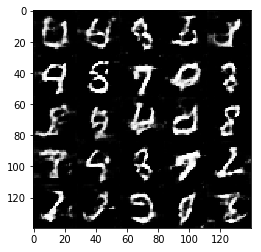

Epoch 1/2... Batch 710... Discriminator Loss: 0.8827... Generator Loss: 2.5080
Epoch 1/2... Batch 720... Discriminator Loss: 0.7524... Generator Loss: 1.4931
Epoch 1/2... Batch 730... Discriminator Loss: 1.1893... Generator Loss: 0.5743
Epoch 1/2... Batch 740... Discriminator Loss: 0.6466... Generator Loss: 2.0755
Epoch 1/2... Batch 750... Discriminator Loss: 0.9667... Generator Loss: 0.8517
Epoch 1/2... Batch 760... Discriminator Loss: 0.9954... Generator Loss: 2.4754
Epoch 1/2... Batch 770... Discriminator Loss: 0.9311... Generator Loss: 0.8826
Epoch 1/2... Batch 780... Discriminator Loss: 0.6927... Generator Loss: 1.5473
Epoch 1/2... Batch 790... Discriminator Loss: 0.7381... Generator Loss: 1.6313
Epoch 1/2... Batch 800... Discriminator Loss: 0.9049... Generator Loss: 0.8620


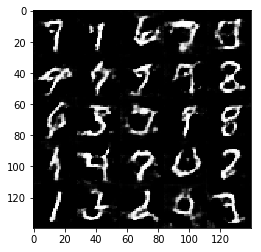

Epoch 1/2... Batch 810... Discriminator Loss: 1.5900... Generator Loss: 3.1805
Epoch 1/2... Batch 820... Discriminator Loss: 1.1126... Generator Loss: 1.2879
Epoch 1/2... Batch 830... Discriminator Loss: 0.9435... Generator Loss: 0.9034
Epoch 1/2... Batch 840... Discriminator Loss: 1.1119... Generator Loss: 3.0896
Epoch 1/2... Batch 850... Discriminator Loss: 0.7726... Generator Loss: 1.2538
Epoch 1/2... Batch 860... Discriminator Loss: 0.8747... Generator Loss: 0.9515
Epoch 1/2... Batch 870... Discriminator Loss: 1.1842... Generator Loss: 0.5351
Epoch 1/2... Batch 880... Discriminator Loss: 1.0909... Generator Loss: 2.5354
Epoch 1/2... Batch 890... Discriminator Loss: 0.9124... Generator Loss: 2.4720
Epoch 1/2... Batch 900... Discriminator Loss: 0.9066... Generator Loss: 1.7377


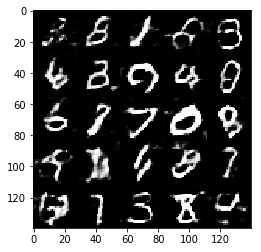

Epoch 1/2... Batch 910... Discriminator Loss: 1.0228... Generator Loss: 0.7775
Epoch 1/2... Batch 920... Discriminator Loss: 1.7904... Generator Loss: 0.2653
Epoch 1/2... Batch 930... Discriminator Loss: 1.0862... Generator Loss: 0.7625
Epoch 2/2... Batch 10... Discriminator Loss: 0.9868... Generator Loss: 1.4163
Epoch 2/2... Batch 20... Discriminator Loss: 0.9705... Generator Loss: 2.0716
Epoch 2/2... Batch 30... Discriminator Loss: 1.1876... Generator Loss: 1.8879
Epoch 2/2... Batch 40... Discriminator Loss: 0.8771... Generator Loss: 1.4012
Epoch 2/2... Batch 50... Discriminator Loss: 0.9294... Generator Loss: 1.1825
Epoch 2/2... Batch 60... Discriminator Loss: 1.4170... Generator Loss: 0.3880
Epoch 2/2... Batch 70... Discriminator Loss: 1.0204... Generator Loss: 0.6967
Epoch 2/2... Batch 80... Discriminator Loss: 0.9711... Generator Loss: 0.8871
Epoch 2/2... Batch 90... Discriminator Loss: 1.5237... Generator Loss: 0.3990
Epoch 2/2... Batch 100... Discriminator Loss: 1.1984... Gener

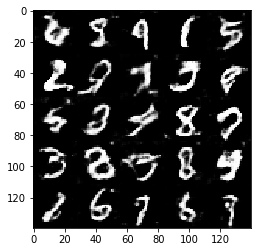

Epoch 2/2... Batch 110... Discriminator Loss: 0.9329... Generator Loss: 1.8742
Epoch 2/2... Batch 120... Discriminator Loss: 1.3932... Generator Loss: 0.4401
Epoch 2/2... Batch 130... Discriminator Loss: 0.9454... Generator Loss: 1.6613
Epoch 2/2... Batch 140... Discriminator Loss: 1.0104... Generator Loss: 2.0512
Epoch 2/2... Batch 150... Discriminator Loss: 0.8564... Generator Loss: 1.6384
Epoch 2/2... Batch 160... Discriminator Loss: 1.0226... Generator Loss: 0.7084
Epoch 2/2... Batch 170... Discriminator Loss: 1.2748... Generator Loss: 0.4793
Epoch 2/2... Batch 180... Discriminator Loss: 0.9584... Generator Loss: 0.7055
Epoch 2/2... Batch 190... Discriminator Loss: 1.7050... Generator Loss: 0.3364
Epoch 2/2... Batch 200... Discriminator Loss: 1.9253... Generator Loss: 3.2414


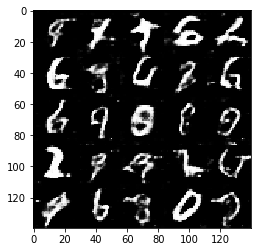

Epoch 2/2... Batch 210... Discriminator Loss: 0.9831... Generator Loss: 0.8580
Epoch 2/2... Batch 220... Discriminator Loss: 1.3030... Generator Loss: 2.3199
Epoch 2/2... Batch 230... Discriminator Loss: 1.7661... Generator Loss: 0.2964
Epoch 2/2... Batch 240... Discriminator Loss: 1.2375... Generator Loss: 1.1527
Epoch 2/2... Batch 250... Discriminator Loss: 1.6337... Generator Loss: 0.3191
Epoch 2/2... Batch 260... Discriminator Loss: 1.2122... Generator Loss: 0.5223
Epoch 2/2... Batch 270... Discriminator Loss: 1.6833... Generator Loss: 0.4776
Epoch 2/2... Batch 280... Discriminator Loss: 1.2858... Generator Loss: 0.4538
Epoch 2/2... Batch 290... Discriminator Loss: 0.8911... Generator Loss: 1.3346
Epoch 2/2... Batch 300... Discriminator Loss: 0.7358... Generator Loss: 1.3502


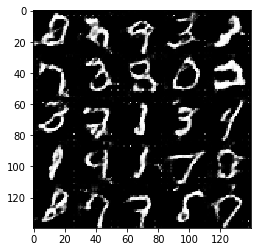

Epoch 2/2... Batch 310... Discriminator Loss: 0.6834... Generator Loss: 1.4458
Epoch 2/2... Batch 320... Discriminator Loss: 0.9672... Generator Loss: 1.4012
Epoch 2/2... Batch 330... Discriminator Loss: 1.2188... Generator Loss: 0.9122
Epoch 2/2... Batch 340... Discriminator Loss: 1.0985... Generator Loss: 1.0549
Epoch 2/2... Batch 350... Discriminator Loss: 1.0993... Generator Loss: 0.8467
Epoch 2/2... Batch 360... Discriminator Loss: 1.2607... Generator Loss: 0.5413
Epoch 2/2... Batch 370... Discriminator Loss: 0.9304... Generator Loss: 0.9376
Epoch 2/2... Batch 380... Discriminator Loss: 1.3135... Generator Loss: 0.5636
Epoch 2/2... Batch 390... Discriminator Loss: 1.1498... Generator Loss: 0.5919
Epoch 2/2... Batch 400... Discriminator Loss: 1.1063... Generator Loss: 0.7242


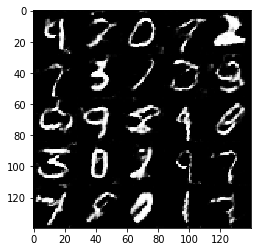

Epoch 2/2... Batch 410... Discriminator Loss: 1.0693... Generator Loss: 0.7999
Epoch 2/2... Batch 420... Discriminator Loss: 0.8055... Generator Loss: 1.3423
Epoch 2/2... Batch 430... Discriminator Loss: 0.9720... Generator Loss: 0.7402
Epoch 2/2... Batch 440... Discriminator Loss: 1.3140... Generator Loss: 0.9459
Epoch 2/2... Batch 450... Discriminator Loss: 0.9355... Generator Loss: 1.1662
Epoch 2/2... Batch 460... Discriminator Loss: 1.1720... Generator Loss: 0.6839
Epoch 2/2... Batch 470... Discriminator Loss: 1.0321... Generator Loss: 0.8319
Epoch 2/2... Batch 480... Discriminator Loss: 1.1406... Generator Loss: 0.5682
Epoch 2/2... Batch 490... Discriminator Loss: 1.4074... Generator Loss: 0.4877
Epoch 2/2... Batch 500... Discriminator Loss: 1.0561... Generator Loss: 1.9191


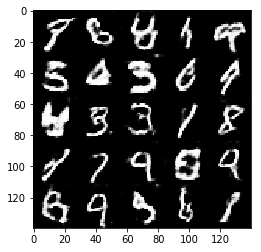

Epoch 2/2... Batch 510... Discriminator Loss: 0.8920... Generator Loss: 1.3833
Epoch 2/2... Batch 520... Discriminator Loss: 0.6164... Generator Loss: 1.3055
Epoch 2/2... Batch 530... Discriminator Loss: 1.4987... Generator Loss: 0.3990
Epoch 2/2... Batch 540... Discriminator Loss: 1.0392... Generator Loss: 0.7661
Epoch 2/2... Batch 550... Discriminator Loss: 1.0713... Generator Loss: 1.6712
Epoch 2/2... Batch 560... Discriminator Loss: 0.6811... Generator Loss: 1.5126
Epoch 2/2... Batch 570... Discriminator Loss: 1.0501... Generator Loss: 0.6510
Epoch 2/2... Batch 580... Discriminator Loss: 0.5141... Generator Loss: 1.7363
Epoch 2/2... Batch 590... Discriminator Loss: 1.0044... Generator Loss: 0.7514
Epoch 2/2... Batch 600... Discriminator Loss: 1.9021... Generator Loss: 0.2756


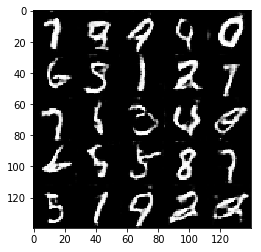

Epoch 2/2... Batch 610... Discriminator Loss: 0.7053... Generator Loss: 2.3574
Epoch 2/2... Batch 620... Discriminator Loss: 0.9715... Generator Loss: 0.8462
Epoch 2/2... Batch 630... Discriminator Loss: 0.5235... Generator Loss: 2.0459
Epoch 2/2... Batch 640... Discriminator Loss: 1.5119... Generator Loss: 0.4335
Epoch 2/2... Batch 650... Discriminator Loss: 1.0505... Generator Loss: 0.7123
Epoch 2/2... Batch 660... Discriminator Loss: 0.7506... Generator Loss: 1.0205
Epoch 2/2... Batch 670... Discriminator Loss: 0.6843... Generator Loss: 1.1234
Epoch 2/2... Batch 680... Discriminator Loss: 1.5795... Generator Loss: 0.4497
Epoch 2/2... Batch 690... Discriminator Loss: 0.9810... Generator Loss: 0.7802
Epoch 2/2... Batch 700... Discriminator Loss: 0.7313... Generator Loss: 2.2445


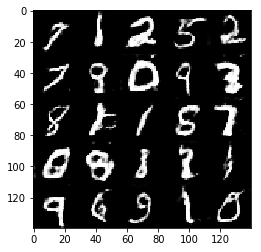

Epoch 2/2... Batch 710... Discriminator Loss: 0.5300... Generator Loss: 1.4878
Epoch 2/2... Batch 720... Discriminator Loss: 1.2696... Generator Loss: 3.6141
Epoch 2/2... Batch 730... Discriminator Loss: 1.2762... Generator Loss: 0.6289
Epoch 2/2... Batch 740... Discriminator Loss: 0.8010... Generator Loss: 1.7715
Epoch 2/2... Batch 750... Discriminator Loss: 0.9883... Generator Loss: 0.9280
Epoch 2/2... Batch 760... Discriminator Loss: 0.9452... Generator Loss: 2.3762
Epoch 2/2... Batch 770... Discriminator Loss: 0.9533... Generator Loss: 0.7545
Epoch 2/2... Batch 780... Discriminator Loss: 1.6284... Generator Loss: 0.3272
Epoch 2/2... Batch 790... Discriminator Loss: 0.7253... Generator Loss: 1.6694
Epoch 2/2... Batch 800... Discriminator Loss: 0.6397... Generator Loss: 2.2977


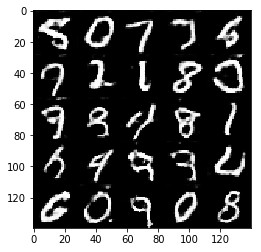

Epoch 2/2... Batch 810... Discriminator Loss: 0.9645... Generator Loss: 0.7709
Epoch 2/2... Batch 820... Discriminator Loss: 1.1048... Generator Loss: 2.5831
Epoch 2/2... Batch 830... Discriminator Loss: 0.6298... Generator Loss: 1.4857
Epoch 2/2... Batch 840... Discriminator Loss: 1.6340... Generator Loss: 0.3618
Epoch 2/2... Batch 850... Discriminator Loss: 1.6523... Generator Loss: 0.3882
Epoch 2/2... Batch 860... Discriminator Loss: 0.4489... Generator Loss: 1.6307
Epoch 2/2... Batch 870... Discriminator Loss: 0.7312... Generator Loss: 1.0536
Epoch 2/2... Batch 880... Discriminator Loss: 4.2031... Generator Loss: 7.1689
Epoch 2/2... Batch 890... Discriminator Loss: 1.1874... Generator Loss: 0.6960
Epoch 2/2... Batch 900... Discriminator Loss: 0.7838... Generator Loss: 1.2753


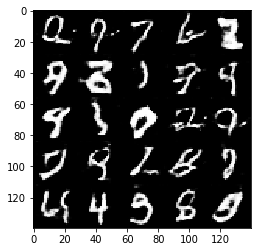

Epoch 2/2... Batch 910... Discriminator Loss: 1.1370... Generator Loss: 0.6268
Epoch 2/2... Batch 920... Discriminator Loss: 0.7935... Generator Loss: 1.2312
Epoch 2/2... Batch 930... Discriminator Loss: 0.7893... Generator Loss: 1.3096


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.3746... Generator Loss: 3.5331
Epoch 1/1... Batch 20... Discriminator Loss: 2.4327... Generator Loss: 0.9266
Epoch 1/1... Batch 30... Discriminator Loss: 3.3707... Generator Loss: 0.2738
Epoch 1/1... Batch 40... Discriminator Loss: 0.1204... Generator Loss: 6.0397
Epoch 1/1... Batch 50... Discriminator Loss: 0.7164... Generator Loss: 1.3456
Epoch 1/1... Batch 60... Discriminator Loss: 0.8941... Generator Loss: 5.5314
Epoch 1/1... Batch 70... Discriminator Loss: 0.1769... Generator Loss: 3.0561
Epoch 1/1... Batch 80... Discriminator Loss: 0.3516... Generator Loss: 4.9778
Epoch 1/1... Batch 90... Discriminator Loss: 2.4181... Generator Loss: 0.3005
Epoch 1/1... Batch 100... Discriminator Loss: 0.4497... Generator Loss: 2.0292


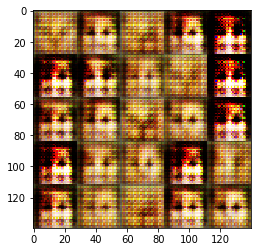

Epoch 1/1... Batch 110... Discriminator Loss: 1.2795... Generator Loss: 0.6485
Epoch 1/1... Batch 120... Discriminator Loss: 0.3981... Generator Loss: 5.3355
Epoch 1/1... Batch 130... Discriminator Loss: 2.1703... Generator Loss: 5.2141
Epoch 1/1... Batch 140... Discriminator Loss: 1.1453... Generator Loss: 3.7465
Epoch 1/1... Batch 150... Discriminator Loss: 2.8828... Generator Loss: 6.8713
Epoch 1/1... Batch 160... Discriminator Loss: 1.7836... Generator Loss: 0.9555
Epoch 1/1... Batch 170... Discriminator Loss: 0.6455... Generator Loss: 1.9490
Epoch 1/1... Batch 180... Discriminator Loss: 0.6330... Generator Loss: 1.4594
Epoch 1/1... Batch 190... Discriminator Loss: 0.6219... Generator Loss: 1.5828
Epoch 1/1... Batch 200... Discriminator Loss: 1.1492... Generator Loss: 0.9694


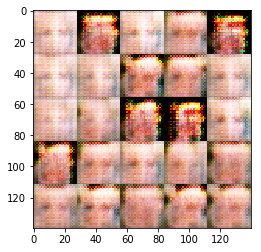

Epoch 1/1... Batch 210... Discriminator Loss: 0.5559... Generator Loss: 2.8369
Epoch 1/1... Batch 220... Discriminator Loss: 0.8616... Generator Loss: 1.2911
Epoch 1/1... Batch 230... Discriminator Loss: 0.9281... Generator Loss: 0.9067
Epoch 1/1... Batch 240... Discriminator Loss: 1.1453... Generator Loss: 0.5412
Epoch 1/1... Batch 250... Discriminator Loss: 1.4878... Generator Loss: 0.4779
Epoch 1/1... Batch 260... Discriminator Loss: 1.3171... Generator Loss: 0.7192
Epoch 1/1... Batch 270... Discriminator Loss: 0.9060... Generator Loss: 1.3725
Epoch 1/1... Batch 280... Discriminator Loss: 0.9554... Generator Loss: 0.9165
Epoch 1/1... Batch 290... Discriminator Loss: 0.7718... Generator Loss: 3.4872
Epoch 1/1... Batch 300... Discriminator Loss: 3.8595... Generator Loss: 6.4046


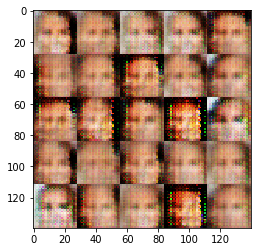

Epoch 1/1... Batch 310... Discriminator Loss: 0.6085... Generator Loss: 1.7522
Epoch 1/1... Batch 320... Discriminator Loss: 1.0035... Generator Loss: 1.0872
Epoch 1/1... Batch 330... Discriminator Loss: 0.7757... Generator Loss: 1.5004
Epoch 1/1... Batch 340... Discriminator Loss: 1.4799... Generator Loss: 0.9706
Epoch 1/1... Batch 350... Discriminator Loss: 0.9527... Generator Loss: 1.2712
Epoch 1/1... Batch 360... Discriminator Loss: 1.3308... Generator Loss: 1.1913
Epoch 1/1... Batch 370... Discriminator Loss: 1.5487... Generator Loss: 1.8676
Epoch 1/1... Batch 380... Discriminator Loss: 1.3786... Generator Loss: 1.2004
Epoch 1/1... Batch 390... Discriminator Loss: 1.7363... Generator Loss: 2.0589
Epoch 1/1... Batch 400... Discriminator Loss: 1.3197... Generator Loss: 0.8497


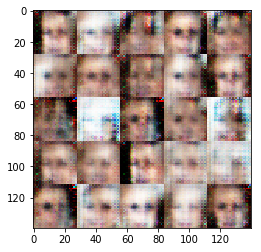

Epoch 1/1... Batch 410... Discriminator Loss: 1.0702... Generator Loss: 0.6288
Epoch 1/1... Batch 420... Discriminator Loss: 1.0239... Generator Loss: 0.8447
Epoch 1/1... Batch 430... Discriminator Loss: 0.8067... Generator Loss: 0.9649
Epoch 1/1... Batch 440... Discriminator Loss: 0.5257... Generator Loss: 1.4125
Epoch 1/1... Batch 450... Discriminator Loss: 1.2531... Generator Loss: 0.8483
Epoch 1/1... Batch 460... Discriminator Loss: 1.2062... Generator Loss: 0.8741
Epoch 1/1... Batch 470... Discriminator Loss: 1.2068... Generator Loss: 0.8690
Epoch 1/1... Batch 480... Discriminator Loss: 1.0394... Generator Loss: 1.0460
Epoch 1/1... Batch 490... Discriminator Loss: 1.6059... Generator Loss: 1.9501
Epoch 1/1... Batch 500... Discriminator Loss: 1.1750... Generator Loss: 1.2358


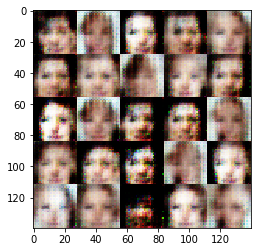

Epoch 1/1... Batch 510... Discriminator Loss: 1.4688... Generator Loss: 0.9968
Epoch 1/1... Batch 520... Discriminator Loss: 0.9783... Generator Loss: 1.1076
Epoch 1/1... Batch 530... Discriminator Loss: 1.0164... Generator Loss: 1.2523
Epoch 1/1... Batch 540... Discriminator Loss: 2.0582... Generator Loss: 0.3020
Epoch 1/1... Batch 550... Discriminator Loss: 1.0769... Generator Loss: 0.7544
Epoch 1/1... Batch 560... Discriminator Loss: 1.3803... Generator Loss: 1.5712
Epoch 1/1... Batch 570... Discriminator Loss: 1.2256... Generator Loss: 2.0512
Epoch 1/1... Batch 580... Discriminator Loss: 1.1935... Generator Loss: 0.5381
Epoch 1/1... Batch 590... Discriminator Loss: 1.0957... Generator Loss: 0.8711
Epoch 1/1... Batch 600... Discriminator Loss: 1.6456... Generator Loss: 0.3252


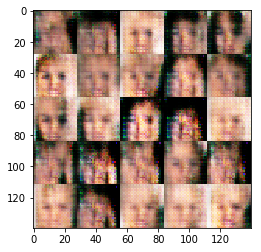

Epoch 1/1... Batch 610... Discriminator Loss: 1.6318... Generator Loss: 0.3277
Epoch 1/1... Batch 620... Discriminator Loss: 0.9747... Generator Loss: 1.2538
Epoch 1/1... Batch 630... Discriminator Loss: 0.7559... Generator Loss: 1.3121
Epoch 1/1... Batch 640... Discriminator Loss: 1.3513... Generator Loss: 0.5142
Epoch 1/1... Batch 650... Discriminator Loss: 1.0695... Generator Loss: 0.6509
Epoch 1/1... Batch 660... Discriminator Loss: 1.1137... Generator Loss: 0.8114
Epoch 1/1... Batch 670... Discriminator Loss: 1.2377... Generator Loss: 1.0611
Epoch 1/1... Batch 680... Discriminator Loss: 1.0191... Generator Loss: 0.6950
Epoch 1/1... Batch 690... Discriminator Loss: 0.7838... Generator Loss: 1.4576
Epoch 1/1... Batch 700... Discriminator Loss: 1.0266... Generator Loss: 0.7601


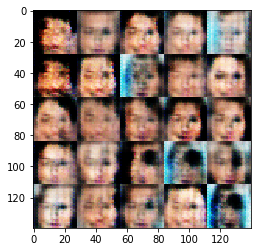

Epoch 1/1... Batch 710... Discriminator Loss: 2.5630... Generator Loss: 3.8139
Epoch 1/1... Batch 720... Discriminator Loss: 1.2729... Generator Loss: 1.0052
Epoch 1/1... Batch 730... Discriminator Loss: 2.9920... Generator Loss: 3.4342
Epoch 1/1... Batch 740... Discriminator Loss: 1.1041... Generator Loss: 1.0571
Epoch 1/1... Batch 750... Discriminator Loss: 1.2696... Generator Loss: 0.6085
Epoch 1/1... Batch 760... Discriminator Loss: 0.9174... Generator Loss: 1.0636
Epoch 1/1... Batch 770... Discriminator Loss: 0.9297... Generator Loss: 0.8470
Epoch 1/1... Batch 780... Discriminator Loss: 1.2577... Generator Loss: 1.0000
Epoch 1/1... Batch 790... Discriminator Loss: 1.2234... Generator Loss: 0.4826
Epoch 1/1... Batch 800... Discriminator Loss: 2.2510... Generator Loss: 2.5533


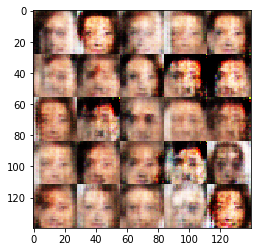

Epoch 1/1... Batch 810... Discriminator Loss: 0.8632... Generator Loss: 1.1995
Epoch 1/1... Batch 820... Discriminator Loss: 0.9790... Generator Loss: 1.3015
Epoch 1/1... Batch 830... Discriminator Loss: 1.6762... Generator Loss: 2.8579
Epoch 1/1... Batch 840... Discriminator Loss: 1.1727... Generator Loss: 0.7720
Epoch 1/1... Batch 850... Discriminator Loss: 1.3723... Generator Loss: 0.4778
Epoch 1/1... Batch 860... Discriminator Loss: 1.0247... Generator Loss: 0.7305
Epoch 1/1... Batch 870... Discriminator Loss: 1.0399... Generator Loss: 0.7481
Epoch 1/1... Batch 880... Discriminator Loss: 0.8696... Generator Loss: 1.2625
Epoch 1/1... Batch 890... Discriminator Loss: 1.7371... Generator Loss: 0.5358
Epoch 1/1... Batch 900... Discriminator Loss: 1.4476... Generator Loss: 0.4511


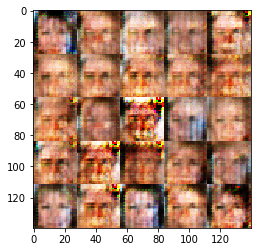

Epoch 1/1... Batch 910... Discriminator Loss: 1.1277... Generator Loss: 1.5897
Epoch 1/1... Batch 920... Discriminator Loss: 0.8831... Generator Loss: 0.7890
Epoch 1/1... Batch 930... Discriminator Loss: 1.0057... Generator Loss: 1.3566
Epoch 1/1... Batch 940... Discriminator Loss: 1.1292... Generator Loss: 1.6190
Epoch 1/1... Batch 950... Discriminator Loss: 1.7681... Generator Loss: 0.3384
Epoch 1/1... Batch 960... Discriminator Loss: 1.0039... Generator Loss: 0.8234
Epoch 1/1... Batch 970... Discriminator Loss: 1.0305... Generator Loss: 0.7908
Epoch 1/1... Batch 980... Discriminator Loss: 0.8553... Generator Loss: 1.2393
Epoch 1/1... Batch 990... Discriminator Loss: 1.1755... Generator Loss: 1.0681
Epoch 1/1... Batch 1000... Discriminator Loss: 0.9383... Generator Loss: 1.4129


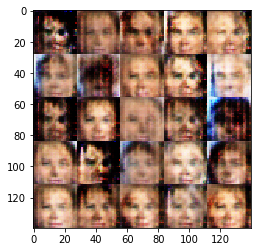

Epoch 1/1... Batch 1010... Discriminator Loss: 2.0345... Generator Loss: 3.1242
Epoch 1/1... Batch 1020... Discriminator Loss: 1.9341... Generator Loss: 0.3159
Epoch 1/1... Batch 1030... Discriminator Loss: 1.1689... Generator Loss: 0.6094
Epoch 1/1... Batch 1040... Discriminator Loss: 1.2758... Generator Loss: 0.5029
Epoch 1/1... Batch 1050... Discriminator Loss: 0.8801... Generator Loss: 1.1213
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0737... Generator Loss: 0.7171
Epoch 1/1... Batch 1070... Discriminator Loss: 2.0439... Generator Loss: 2.5431
Epoch 1/1... Batch 1080... Discriminator Loss: 1.2445... Generator Loss: 0.6999
Epoch 1/1... Batch 1090... Discriminator Loss: 1.1311... Generator Loss: 0.6540
Epoch 1/1... Batch 1100... Discriminator Loss: 0.9135... Generator Loss: 1.2167


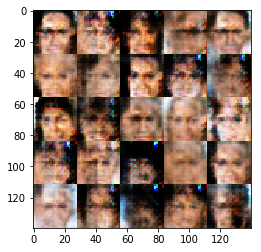

Epoch 1/1... Batch 1110... Discriminator Loss: 0.8291... Generator Loss: 1.1733
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0367... Generator Loss: 2.1319
Epoch 1/1... Batch 1130... Discriminator Loss: 1.4840... Generator Loss: 0.4115
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1230... Generator Loss: 0.6130
Epoch 1/1... Batch 1150... Discriminator Loss: 1.3149... Generator Loss: 0.5176
Epoch 1/1... Batch 1160... Discriminator Loss: 0.9698... Generator Loss: 1.3773
Epoch 1/1... Batch 1170... Discriminator Loss: 1.1778... Generator Loss: 2.3827
Epoch 1/1... Batch 1180... Discriminator Loss: 1.0507... Generator Loss: 1.3270
Epoch 1/1... Batch 1190... Discriminator Loss: 0.9176... Generator Loss: 0.8972
Epoch 1/1... Batch 1200... Discriminator Loss: 0.9853... Generator Loss: 1.5052


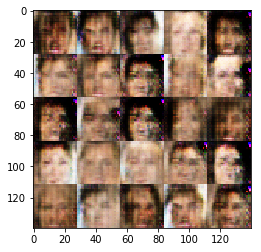

Epoch 1/1... Batch 1210... Discriminator Loss: 0.9331... Generator Loss: 0.7178
Epoch 1/1... Batch 1220... Discriminator Loss: 1.2083... Generator Loss: 1.2313
Epoch 1/1... Batch 1230... Discriminator Loss: 1.2897... Generator Loss: 0.5401
Epoch 1/1... Batch 1240... Discriminator Loss: 1.3413... Generator Loss: 0.6749
Epoch 1/1... Batch 1250... Discriminator Loss: 0.7866... Generator Loss: 0.9337
Epoch 1/1... Batch 1260... Discriminator Loss: 0.8467... Generator Loss: 1.5445
Epoch 1/1... Batch 1270... Discriminator Loss: 1.0175... Generator Loss: 0.8112
Epoch 1/1... Batch 1280... Discriminator Loss: 1.5238... Generator Loss: 0.4495
Epoch 1/1... Batch 1290... Discriminator Loss: 0.7948... Generator Loss: 0.8699
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2050... Generator Loss: 0.7077


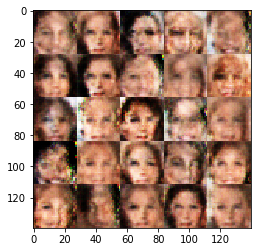

Epoch 1/1... Batch 1310... Discriminator Loss: 1.0253... Generator Loss: 0.8152
Epoch 1/1... Batch 1320... Discriminator Loss: 0.8938... Generator Loss: 1.7227
Epoch 1/1... Batch 1330... Discriminator Loss: 0.8093... Generator Loss: 2.7797
Epoch 1/1... Batch 1340... Discriminator Loss: 0.9671... Generator Loss: 0.9696
Epoch 1/1... Batch 1350... Discriminator Loss: 1.2717... Generator Loss: 0.5373
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2607... Generator Loss: 0.7827
Epoch 1/1... Batch 1370... Discriminator Loss: 0.9035... Generator Loss: 1.7969
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2856... Generator Loss: 0.7986
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1568... Generator Loss: 1.5273
Epoch 1/1... Batch 1400... Discriminator Loss: 0.9269... Generator Loss: 1.6436


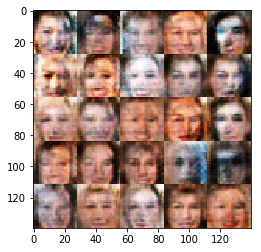

Epoch 1/1... Batch 1410... Discriminator Loss: 1.2414... Generator Loss: 0.7838
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0679... Generator Loss: 1.3942
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2186... Generator Loss: 0.6574
Epoch 1/1... Batch 1440... Discriminator Loss: 0.6564... Generator Loss: 1.3519
Epoch 1/1... Batch 1450... Discriminator Loss: 1.7095... Generator Loss: 2.6493
Epoch 1/1... Batch 1460... Discriminator Loss: 1.0715... Generator Loss: 0.7928
Epoch 1/1... Batch 1470... Discriminator Loss: 0.8373... Generator Loss: 2.5439
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3021... Generator Loss: 1.0314
Epoch 1/1... Batch 1490... Discriminator Loss: 0.8788... Generator Loss: 1.3554
Epoch 1/1... Batch 1500... Discriminator Loss: 0.7737... Generator Loss: 1.9655


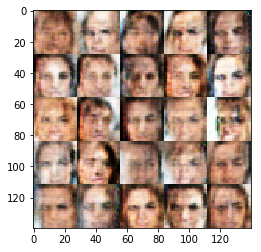

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1237... Generator Loss: 0.9046
Epoch 1/1... Batch 1520... Discriminator Loss: 1.0841... Generator Loss: 0.8525
Epoch 1/1... Batch 1530... Discriminator Loss: 1.0278... Generator Loss: 0.7456
Epoch 1/1... Batch 1540... Discriminator Loss: 1.1421... Generator Loss: 1.2883
Epoch 1/1... Batch 1550... Discriminator Loss: 1.0243... Generator Loss: 1.2261
Epoch 1/1... Batch 1560... Discriminator Loss: 0.9966... Generator Loss: 0.8973
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2869... Generator Loss: 0.6283
Epoch 1/1... Batch 1580... Discriminator Loss: 0.9952... Generator Loss: 1.4031
Epoch 1/1... Batch 1590... Discriminator Loss: 1.4816... Generator Loss: 2.0015
Epoch 1/1... Batch 1600... Discriminator Loss: 1.1621... Generator Loss: 0.6695


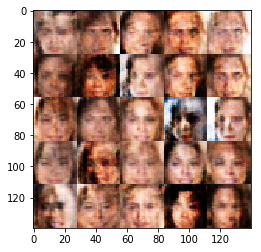

Epoch 1/1... Batch 1610... Discriminator Loss: 0.9826... Generator Loss: 1.1332
Epoch 1/1... Batch 1620... Discriminator Loss: 0.9354... Generator Loss: 0.9117
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0816... Generator Loss: 1.6982
Epoch 1/1... Batch 1640... Discriminator Loss: 0.7800... Generator Loss: 1.6026
Epoch 1/1... Batch 1650... Discriminator Loss: 0.9346... Generator Loss: 1.0234
Epoch 1/1... Batch 1660... Discriminator Loss: 1.2973... Generator Loss: 0.9730
Epoch 1/1... Batch 1670... Discriminator Loss: 1.4204... Generator Loss: 0.4564
Epoch 1/1... Batch 1680... Discriminator Loss: 1.0251... Generator Loss: 1.0474
Epoch 1/1... Batch 1690... Discriminator Loss: 1.0870... Generator Loss: 2.7206
Epoch 1/1... Batch 1700... Discriminator Loss: 0.8490... Generator Loss: 0.9981


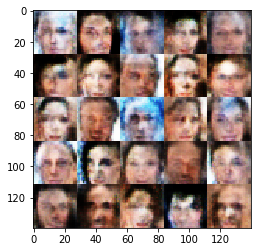

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3342... Generator Loss: 1.9408
Epoch 1/1... Batch 1720... Discriminator Loss: 1.3593... Generator Loss: 0.7635
Epoch 1/1... Batch 1730... Discriminator Loss: 1.1485... Generator Loss: 0.7325
Epoch 1/1... Batch 1740... Discriminator Loss: 0.8869... Generator Loss: 0.9173
Epoch 1/1... Batch 1750... Discriminator Loss: 1.2668... Generator Loss: 0.5854
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1533... Generator Loss: 1.0763
Epoch 1/1... Batch 1770... Discriminator Loss: 1.2623... Generator Loss: 0.5115
Epoch 1/1... Batch 1780... Discriminator Loss: 1.1804... Generator Loss: 0.6395
Epoch 1/1... Batch 1790... Discriminator Loss: 1.0497... Generator Loss: 2.3981
Epoch 1/1... Batch 1800... Discriminator Loss: 2.5177... Generator Loss: 3.4651


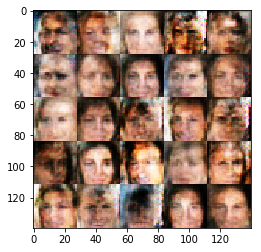

Epoch 1/1... Batch 1810... Discriminator Loss: 0.9339... Generator Loss: 1.0760
Epoch 1/1... Batch 1820... Discriminator Loss: 1.8008... Generator Loss: 0.2346
Epoch 1/1... Batch 1830... Discriminator Loss: 1.0839... Generator Loss: 0.7372
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1819... Generator Loss: 0.6649
Epoch 1/1... Batch 1850... Discriminator Loss: 0.9923... Generator Loss: 1.6264
Epoch 1/1... Batch 1860... Discriminator Loss: 1.3129... Generator Loss: 0.4810
Epoch 1/1... Batch 1870... Discriminator Loss: 1.0306... Generator Loss: 1.5271
Epoch 1/1... Batch 1880... Discriminator Loss: 1.5968... Generator Loss: 0.3447
Epoch 1/1... Batch 1890... Discriminator Loss: 1.0734... Generator Loss: 1.5874
Epoch 1/1... Batch 1900... Discriminator Loss: 1.5107... Generator Loss: 2.1044


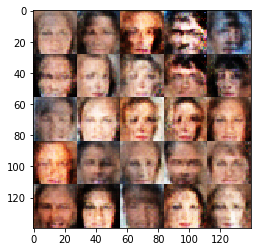

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1774... Generator Loss: 0.6383
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0028... Generator Loss: 0.7381
Epoch 1/1... Batch 1930... Discriminator Loss: 0.9737... Generator Loss: 1.3582
Epoch 1/1... Batch 1940... Discriminator Loss: 1.2117... Generator Loss: 0.7875
Epoch 1/1... Batch 1950... Discriminator Loss: 1.0492... Generator Loss: 0.7973
Epoch 1/1... Batch 1960... Discriminator Loss: 1.0766... Generator Loss: 1.3422
Epoch 1/1... Batch 1970... Discriminator Loss: 1.2537... Generator Loss: 2.6603
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1155... Generator Loss: 0.7627
Epoch 1/1... Batch 1990... Discriminator Loss: 1.1102... Generator Loss: 1.1573
Epoch 1/1... Batch 2000... Discriminator Loss: 1.0109... Generator Loss: 0.9398


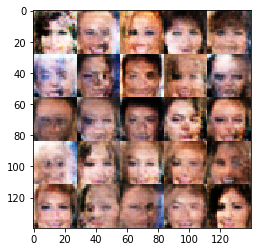

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3156... Generator Loss: 1.4289
Epoch 1/1... Batch 2020... Discriminator Loss: 1.1976... Generator Loss: 0.5297
Epoch 1/1... Batch 2030... Discriminator Loss: 1.1068... Generator Loss: 0.6466
Epoch 1/1... Batch 2040... Discriminator Loss: 0.8145... Generator Loss: 1.1233
Epoch 1/1... Batch 2050... Discriminator Loss: 0.7950... Generator Loss: 1.5849
Epoch 1/1... Batch 2060... Discriminator Loss: 1.0838... Generator Loss: 1.6879
Epoch 1/1... Batch 2070... Discriminator Loss: 0.8198... Generator Loss: 1.0865
Epoch 1/1... Batch 2080... Discriminator Loss: 0.9674... Generator Loss: 0.9359
Epoch 1/1... Batch 2090... Discriminator Loss: 1.0769... Generator Loss: 1.1715
Epoch 1/1... Batch 2100... Discriminator Loss: 1.0581... Generator Loss: 1.2155


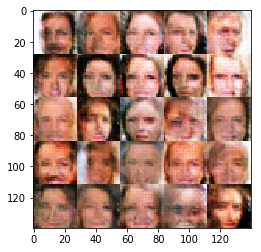

Epoch 1/1... Batch 2110... Discriminator Loss: 1.1756... Generator Loss: 0.5720
Epoch 1/1... Batch 2120... Discriminator Loss: 1.5506... Generator Loss: 0.3555
Epoch 1/1... Batch 2130... Discriminator Loss: 1.3249... Generator Loss: 0.6111
Epoch 1/1... Batch 2140... Discriminator Loss: 1.4357... Generator Loss: 0.3682
Epoch 1/1... Batch 2150... Discriminator Loss: 1.1904... Generator Loss: 0.7249
Epoch 1/1... Batch 2160... Discriminator Loss: 1.2913... Generator Loss: 0.5579
Epoch 1/1... Batch 2170... Discriminator Loss: 1.1768... Generator Loss: 1.2605
Epoch 1/1... Batch 2180... Discriminator Loss: 1.1729... Generator Loss: 0.8780
Epoch 1/1... Batch 2190... Discriminator Loss: 0.8953... Generator Loss: 1.2064
Epoch 1/1... Batch 2200... Discriminator Loss: 1.1264... Generator Loss: 1.6599


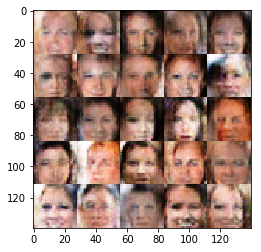

Epoch 1/1... Batch 2210... Discriminator Loss: 0.9758... Generator Loss: 1.0459
Epoch 1/1... Batch 2220... Discriminator Loss: 1.0167... Generator Loss: 1.2820
Epoch 1/1... Batch 2230... Discriminator Loss: 1.1873... Generator Loss: 0.7977
Epoch 1/1... Batch 2240... Discriminator Loss: 0.7158... Generator Loss: 1.5848
Epoch 1/1... Batch 2250... Discriminator Loss: 1.5860... Generator Loss: 0.3360
Epoch 1/1... Batch 2260... Discriminator Loss: 1.2001... Generator Loss: 0.7881
Epoch 1/1... Batch 2270... Discriminator Loss: 1.4382... Generator Loss: 0.3813
Epoch 1/1... Batch 2280... Discriminator Loss: 1.3302... Generator Loss: 0.4507
Epoch 1/1... Batch 2290... Discriminator Loss: 1.1143... Generator Loss: 0.7699
Epoch 1/1... Batch 2300... Discriminator Loss: 1.2179... Generator Loss: 0.9961


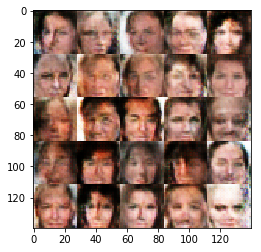

Epoch 1/1... Batch 2310... Discriminator Loss: 0.9369... Generator Loss: 0.8744
Epoch 1/1... Batch 2320... Discriminator Loss: 0.8809... Generator Loss: 1.3048
Epoch 1/1... Batch 2330... Discriminator Loss: 1.2821... Generator Loss: 0.5636
Epoch 1/1... Batch 2340... Discriminator Loss: 0.8245... Generator Loss: 1.4384
Epoch 1/1... Batch 2350... Discriminator Loss: 1.5943... Generator Loss: 2.8450
Epoch 1/1... Batch 2360... Discriminator Loss: 1.0952... Generator Loss: 1.6810
Epoch 1/1... Batch 2370... Discriminator Loss: 0.9293... Generator Loss: 0.8737
Epoch 1/1... Batch 2380... Discriminator Loss: 0.8790... Generator Loss: 0.9943
Epoch 1/1... Batch 2390... Discriminator Loss: 1.3031... Generator Loss: 0.7189
Epoch 1/1... Batch 2400... Discriminator Loss: 0.8521... Generator Loss: 1.5129


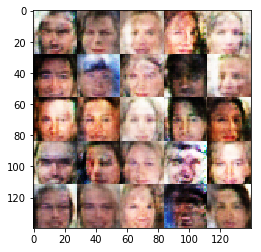

Epoch 1/1... Batch 2410... Discriminator Loss: 1.0711... Generator Loss: 0.6870
Epoch 1/1... Batch 2420... Discriminator Loss: 1.2202... Generator Loss: 0.6691
Epoch 1/1... Batch 2430... Discriminator Loss: 0.7178... Generator Loss: 1.2960
Epoch 1/1... Batch 2440... Discriminator Loss: 1.4197... Generator Loss: 0.4535
Epoch 1/1... Batch 2450... Discriminator Loss: 0.9479... Generator Loss: 1.1388
Epoch 1/1... Batch 2460... Discriminator Loss: 1.0602... Generator Loss: 0.9351
Epoch 1/1... Batch 2470... Discriminator Loss: 0.8496... Generator Loss: 1.0506
Epoch 1/1... Batch 2480... Discriminator Loss: 0.8226... Generator Loss: 1.4884
Epoch 1/1... Batch 2490... Discriminator Loss: 1.2173... Generator Loss: 1.5028
Epoch 1/1... Batch 2500... Discriminator Loss: 1.0048... Generator Loss: 0.8485


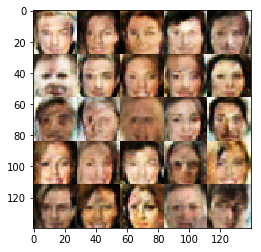

Epoch 1/1... Batch 2510... Discriminator Loss: 0.9726... Generator Loss: 1.1812
Epoch 1/1... Batch 2520... Discriminator Loss: 0.9310... Generator Loss: 1.9619
Epoch 1/1... Batch 2530... Discriminator Loss: 0.9841... Generator Loss: 1.2095
Epoch 1/1... Batch 2540... Discriminator Loss: 1.5546... Generator Loss: 0.3843
Epoch 1/1... Batch 2550... Discriminator Loss: 1.2902... Generator Loss: 1.5007
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2816... Generator Loss: 0.6445
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2027... Generator Loss: 0.5975
Epoch 1/1... Batch 2580... Discriminator Loss: 1.0890... Generator Loss: 1.5815
Epoch 1/1... Batch 2590... Discriminator Loss: 0.8828... Generator Loss: 0.8362
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2110... Generator Loss: 0.7036


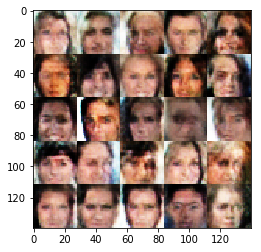

Epoch 1/1... Batch 2610... Discriminator Loss: 2.1855... Generator Loss: 2.5022
Epoch 1/1... Batch 2620... Discriminator Loss: 1.0573... Generator Loss: 0.8430
Epoch 1/1... Batch 2630... Discriminator Loss: 0.9964... Generator Loss: 0.9430
Epoch 1/1... Batch 2640... Discriminator Loss: 1.1130... Generator Loss: 2.0462
Epoch 1/1... Batch 2650... Discriminator Loss: 1.1562... Generator Loss: 1.4101
Epoch 1/1... Batch 2660... Discriminator Loss: 1.0713... Generator Loss: 0.9099
Epoch 1/1... Batch 2670... Discriminator Loss: 1.2781... Generator Loss: 1.4153
Epoch 1/1... Batch 2680... Discriminator Loss: 1.3269... Generator Loss: 0.4267
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2082... Generator Loss: 1.7243
Epoch 1/1... Batch 2700... Discriminator Loss: 0.9609... Generator Loss: 0.9143


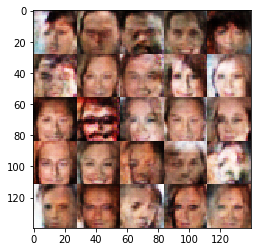

Epoch 1/1... Batch 2710... Discriminator Loss: 1.0165... Generator Loss: 1.4784
Epoch 1/1... Batch 2720... Discriminator Loss: 0.8630... Generator Loss: 1.5355
Epoch 1/1... Batch 2730... Discriminator Loss: 1.1370... Generator Loss: 1.6331
Epoch 1/1... Batch 2740... Discriminator Loss: 1.3767... Generator Loss: 0.6141
Epoch 1/1... Batch 2750... Discriminator Loss: 1.2041... Generator Loss: 0.7657
Epoch 1/1... Batch 2760... Discriminator Loss: 1.0976... Generator Loss: 0.6647
Epoch 1/1... Batch 2770... Discriminator Loss: 1.1756... Generator Loss: 0.7804
Epoch 1/1... Batch 2780... Discriminator Loss: 1.1396... Generator Loss: 0.6079
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1073... Generator Loss: 0.6418
Epoch 1/1... Batch 2800... Discriminator Loss: 0.8915... Generator Loss: 1.0200


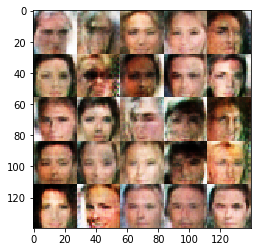

Epoch 1/1... Batch 2810... Discriminator Loss: 1.0583... Generator Loss: 0.8066
Epoch 1/1... Batch 2820... Discriminator Loss: 1.3581... Generator Loss: 0.5227
Epoch 1/1... Batch 2830... Discriminator Loss: 0.9007... Generator Loss: 1.1658
Epoch 1/1... Batch 2840... Discriminator Loss: 0.8656... Generator Loss: 1.0967
Epoch 1/1... Batch 2850... Discriminator Loss: 0.6432... Generator Loss: 1.7694
Epoch 1/1... Batch 2860... Discriminator Loss: 1.0733... Generator Loss: 1.1149
Epoch 1/1... Batch 2870... Discriminator Loss: 1.1343... Generator Loss: 0.7207
Epoch 1/1... Batch 2880... Discriminator Loss: 1.2438... Generator Loss: 0.6650
Epoch 1/1... Batch 2890... Discriminator Loss: 1.2650... Generator Loss: 0.6503
Epoch 1/1... Batch 2900... Discriminator Loss: 1.8376... Generator Loss: 0.2976


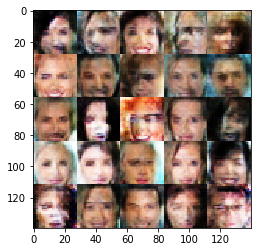

Epoch 1/1... Batch 2910... Discriminator Loss: 1.0590... Generator Loss: 0.8565
Epoch 1/1... Batch 2920... Discriminator Loss: 1.2599... Generator Loss: 2.7177
Epoch 1/1... Batch 2930... Discriminator Loss: 1.6252... Generator Loss: 0.3621
Epoch 1/1... Batch 2940... Discriminator Loss: 0.9344... Generator Loss: 0.9199
Epoch 1/1... Batch 2950... Discriminator Loss: 1.1417... Generator Loss: 2.1795
Epoch 1/1... Batch 2960... Discriminator Loss: 0.8548... Generator Loss: 1.2078
Epoch 1/1... Batch 2970... Discriminator Loss: 1.2299... Generator Loss: 2.3139
Epoch 1/1... Batch 2980... Discriminator Loss: 0.8888... Generator Loss: 1.2107
Epoch 1/1... Batch 2990... Discriminator Loss: 1.0378... Generator Loss: 0.7651
Epoch 1/1... Batch 3000... Discriminator Loss: 1.0226... Generator Loss: 0.8490


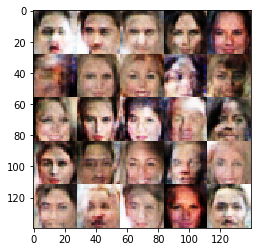

Epoch 1/1... Batch 3010... Discriminator Loss: 0.9971... Generator Loss: 1.1259
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2481... Generator Loss: 0.4983
Epoch 1/1... Batch 3030... Discriminator Loss: 1.0409... Generator Loss: 0.7868
Epoch 1/1... Batch 3040... Discriminator Loss: 1.0484... Generator Loss: 1.1485
Epoch 1/1... Batch 3050... Discriminator Loss: 1.0132... Generator Loss: 1.2221
Epoch 1/1... Batch 3060... Discriminator Loss: 0.9846... Generator Loss: 1.1359
Epoch 1/1... Batch 3070... Discriminator Loss: 1.4340... Generator Loss: 0.3792
Epoch 1/1... Batch 3080... Discriminator Loss: 0.9258... Generator Loss: 0.7753
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1513... Generator Loss: 0.9615
Epoch 1/1... Batch 3100... Discriminator Loss: 1.0923... Generator Loss: 1.0450


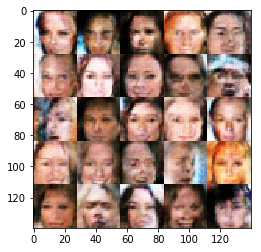

Epoch 1/1... Batch 3110... Discriminator Loss: 0.9330... Generator Loss: 0.9492
Epoch 1/1... Batch 3120... Discriminator Loss: 1.0141... Generator Loss: 1.1935
Epoch 1/1... Batch 3130... Discriminator Loss: 0.8416... Generator Loss: 1.2835
Epoch 1/1... Batch 3140... Discriminator Loss: 0.8929... Generator Loss: 1.5939
Epoch 1/1... Batch 3150... Discriminator Loss: 1.4245... Generator Loss: 0.4705
Epoch 1/1... Batch 3160... Discriminator Loss: 0.9397... Generator Loss: 1.0094


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.